# Capstone Project - The Battle of Neighborhoods

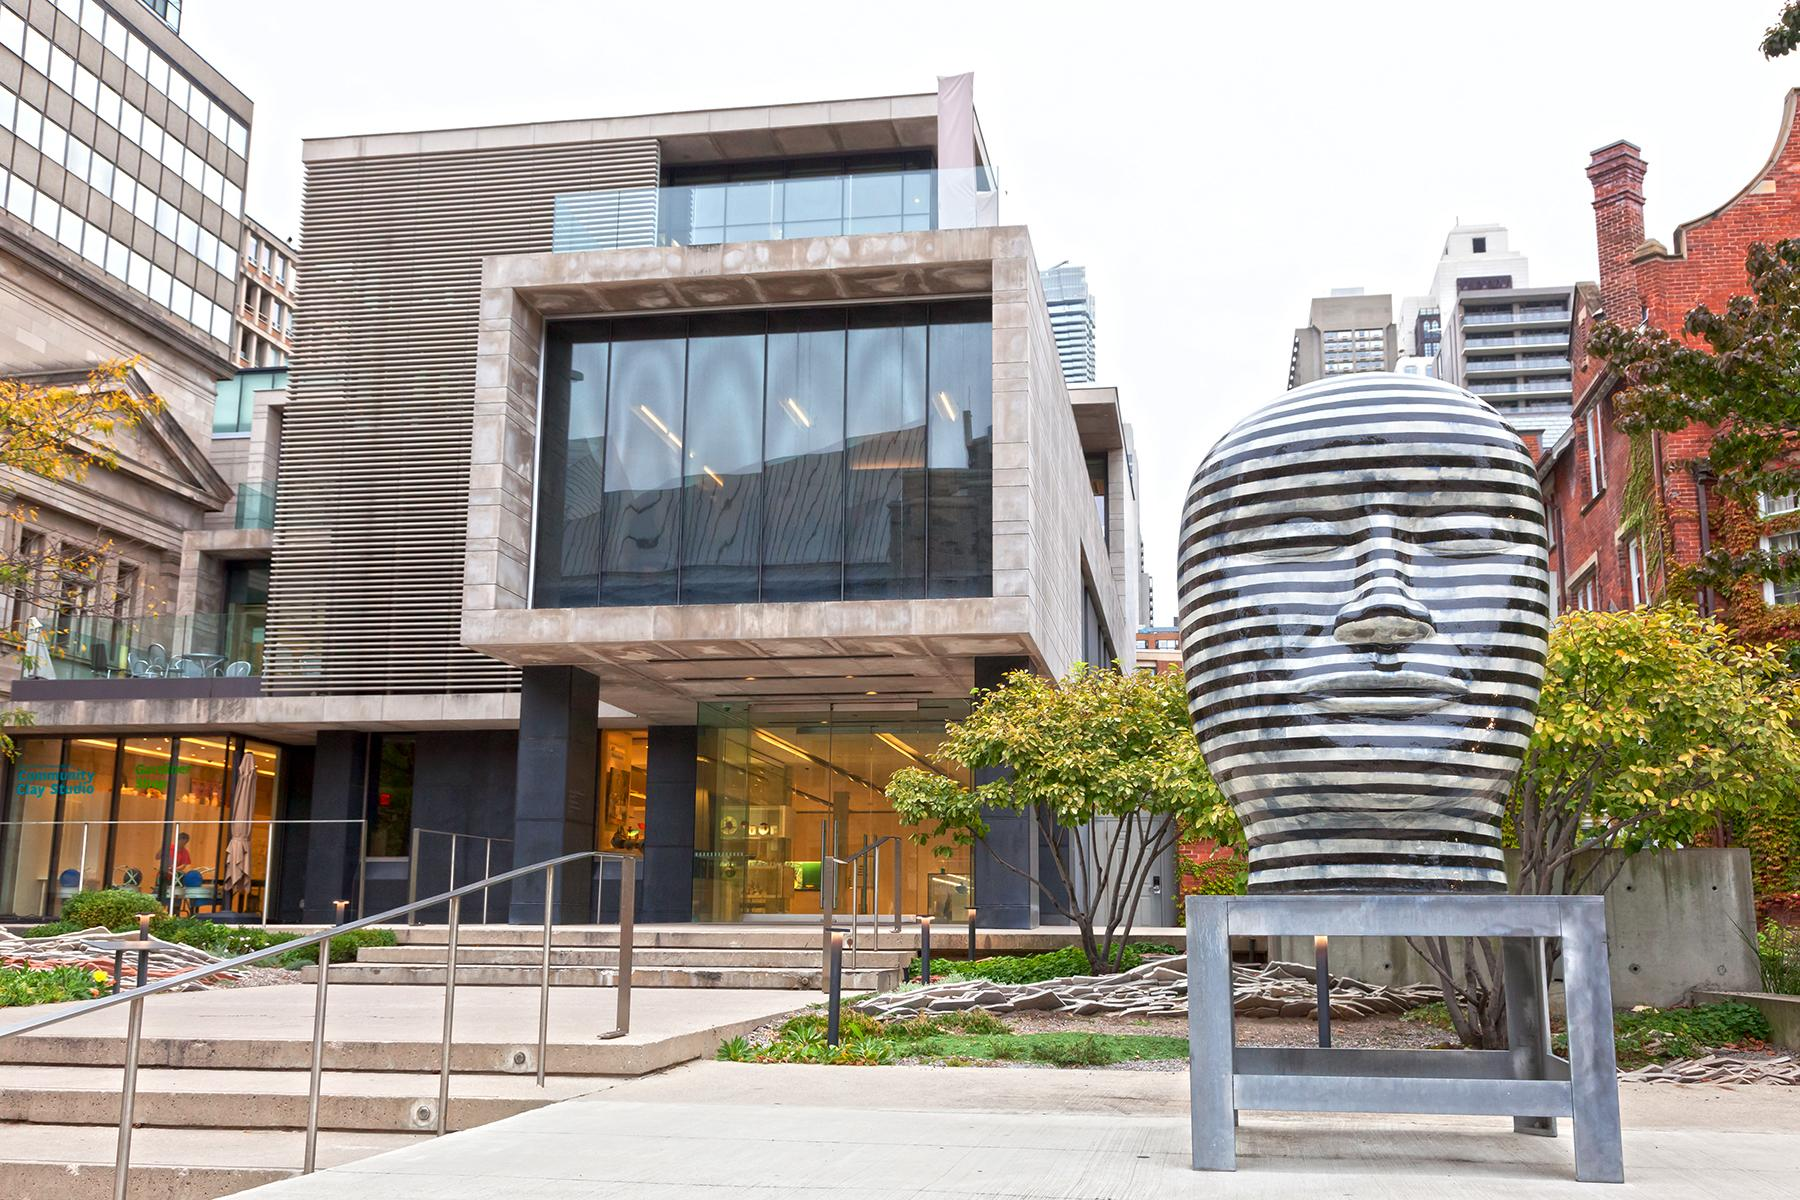

In [1]:
from IPython.display import Image
Image(filename='TorontoMuseumSample.jpg', width=400, height=400)

## Introduction/Business Problem

Toronto is the largest city if Canada and home of many touristic attractions. The city is full of museums, theatres, art galleries and festival events.
The Toronto City Culture Association heard about the capabilities of Data Science and were interested in a working with us to create a recommendation system for city visitors, based on where they planned to stay.
As such, they contacted us, proposing the project with a list of requirements.

#### Requirements
- The system should be capable of get the list of all cultural places in Toronto, worth visiting (e.g.Museums);
- Be able to rate the places according to typical user experience
- Get the top 3 cultural places
- Cluster the selected places by Neighbourhood
- Display the results Graphically on a map
- Create bar graphs analysing the results

## Data

In order to be able to carry out this project we need data from a few sources:

**1 Wikipedia website - we need the information regarding the Boroughs and Neighbourhoods of Toronto**

    https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M
 

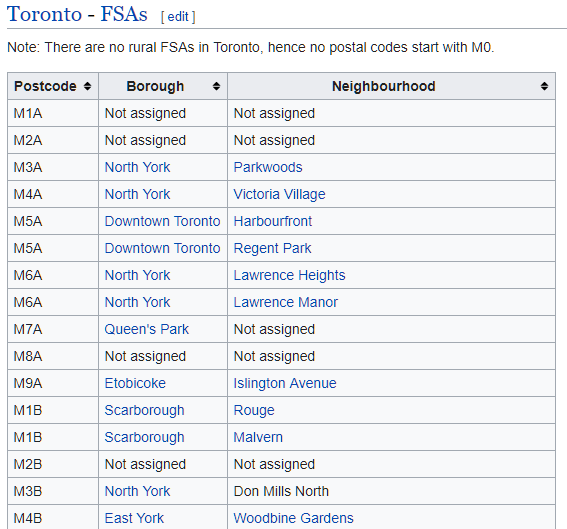

In [2]:
Image(filename='Toronto_Postcodes.png', width=400, height=400)


**2 Foursquare website:**
    - from here we can extract the information about the list of all Cultural venues of Toronto
    - we can also see the popularity of each venue to create our top list

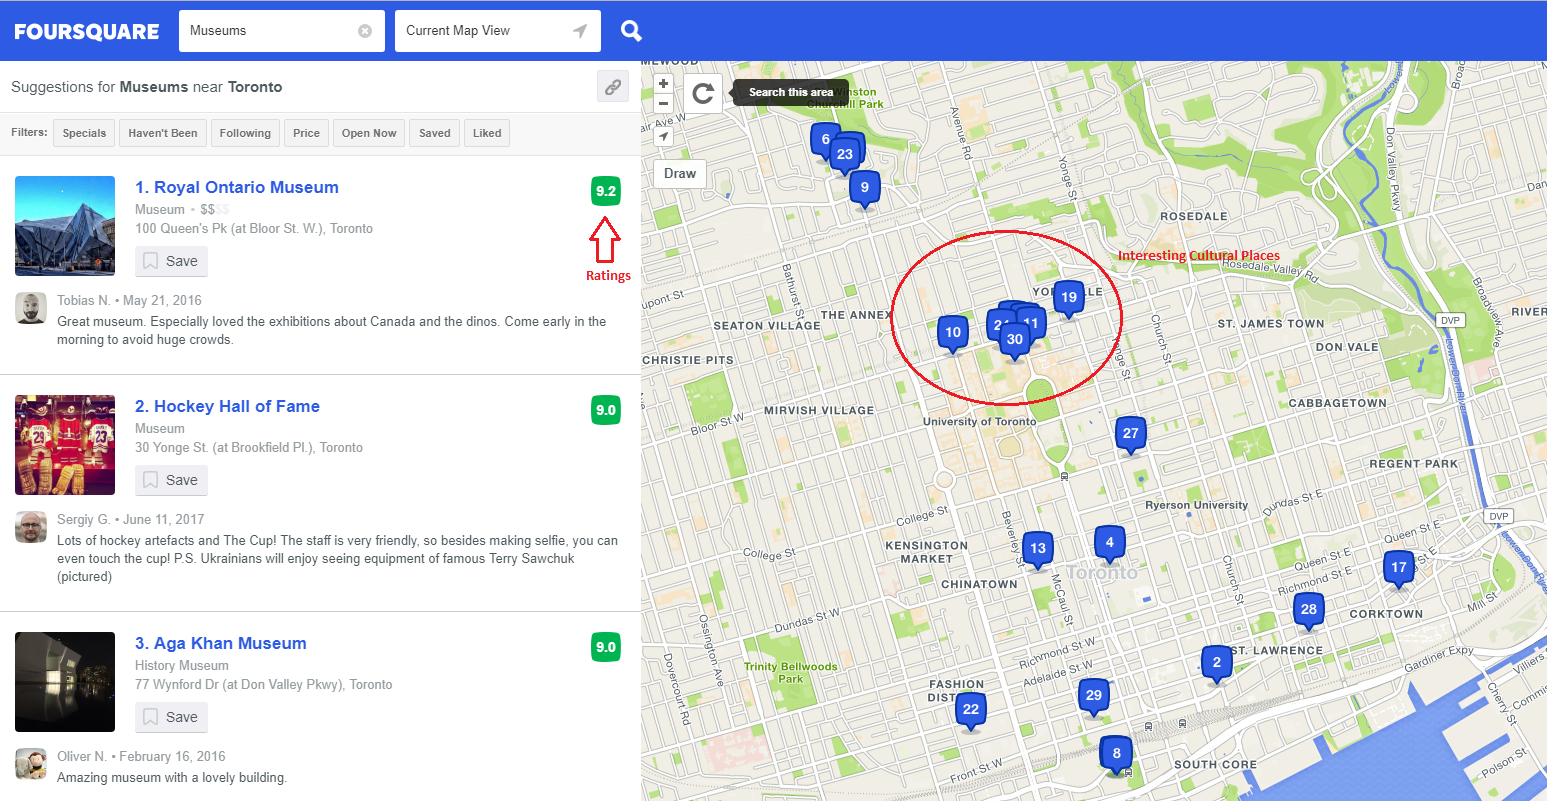

In [3]:
Image(filename='FoursquareToronto.png', width=800, height=600)

**3 Geospatial_Coordinates.csv file which contains the coordinates for each Toronto PostCode**

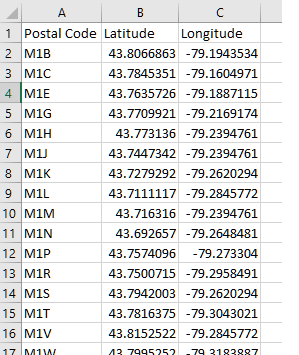

In [4]:
Image(filename='Toronto_csv.png', width=400, height=400)

### ----------------------------------------------------------------------
### ----------------------------------------------------------------------

 ## Development section

In [19]:
#Install required libraries
!conda install lxml --yes
!conda install html5lib --yes
!conda install requests --yes
!conda install geopy --yes

Solving environment: done

# All requested packages already installed.

Solving environment: | 
  - anaconda::html5lib-0.9999999-py36_0
  - defaults::html5lib-0.9999999-py36done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.



#### Required imports

In [21]:
#!conda config --append channels conda-forge
#!conda install --yes --prefix {sys.prefix} geopy
#!conda install --yes --prefix {sys.prefix} folium
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim
import folium
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors

#### Open file and transform it on a soup object (bs4.BeautifulSoup)

In [7]:
response = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')
soup = BeautifulSoup(response.text,'lxml')

In [8]:
myTable = soup.find('table')

##### Now that we have the table, let's loop through the rows and create a list for each cell

In [9]:
table_list = []

for row in myTable.tbody.find_all('tr'):
    row_list = []
    for cell in row.find_all('td'):
        #print(cell.text.strip())
        row_list.append(cell.text.strip())
    
    #Make sure to ignore entries that haven't got a borough
    if len(row_list) > 0 and row_list[1] != 'Not assigned':
        #Define "Not assigned" neighbourhoods as their borough name
        if row_list[2] == 'Not assigned':
            row_list[2] = row_list[1]
        
        table_list.append(row_list)

##### Here we are going to treat multiple postcode rows...

In [10]:
loaded_postcodes = []
unique_postcode_table_list = []
remaining_rows = []

#print(len(table_list)) #212

for el in table_list:
    #print(el)
    
    if loaded_postcodes.count(el[0]) == 0: #new item, load normally
        loaded_postcodes.append(el[0]) #increment loaded postcodes
        unique_postcode_table_list.append(el)
    else:
        remaining_rows.append(el)
        

for el in remaining_rows:
    postcode = el[0]
    neighbourhood = el[2]
    
    for unique_el in unique_postcode_table_list:
        if unique_el[0] == postcode:
            unique_postcode_table_list[unique_postcode_table_list.index(unique_el)][2] = unique_postcode_table_list[unique_postcode_table_list.index(unique_el)][2] + ', ' + neighbourhood
            break

#### Now that we have the data, just create a dataframe and populate it

In [11]:
# define the dataframe columns
column_names = ['PostalCode', 'Borough', 'Neighborhood'] 

# instantiate the dataframe
ca_postcodes_df = pd.DataFrame(columns=column_names)


for item in unique_postcode_table_list:
    PostalCode = item[0]
    Borough = item[1]
    Neighborhood = item[2]
    
    ca_postcodes_df = ca_postcodes_df.append({'PostalCode': PostalCode,
                                              'Borough': Borough,
                                              'Neighborhood': Neighborhood}, ignore_index=True)
        
ca_postcodes_df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Harbourfront, Regent Park"
3,M6A,North York,"Lawrence Heights, Lawrence Manor"
4,M7A,Queen's Park,Queen's Park


## Next, read from csv and get latitude/longitude

In [13]:
lat_log_df = pd.read_csv('Geospatial_Coordinates.csv')

In [14]:
lat_log_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


#### Merge both dataframes

In [15]:
lat_log_df_new = lat_log_df.copy()
#lat_log_df_new['Postal Code'] = lat_log_df_new['PostalCode']
lat_log_df_new.rename(columns={'Postal Code':'PostalCode'}, inplace=True)
#lat_log_df_new
df_pc_lat_long = pd.merge(ca_postcodes_df, lat_log_df_new, how='inner', on = 'PostalCode')
df_pc_lat_long.head()
    

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763
4,M7A,Queen's Park,Queen's Park,43.662301,-79.389494


### Time to Explore and cluster the neighborhoods in Toronto

##### Use geopy library to get the latitude and longitude values of Toronto, Toronto

In [16]:
#Use only boroughs that contain "Toronto", for simplicity

toronto_data = df_pc_lat_long[df_pc_lat_long['Borough'].str.contains('Toronto')].reset_index(drop=True)
toronto_data.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636
1,M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937
2,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
3,M4E,East Toronto,The Beaches,43.676357,-79.293031
4,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306


In [17]:
address = 'Toronto, Ca'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.18.1" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  This is separate from the ipykernel package so we can avoid doing imports until


The geograpical coordinate of Toronto are 43.7170226, -79.4197830350134.


#### Create a map of Toronto with neighborhoods superimposed on top.

In [211]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_data['Latitude'], toronto_data['Longitude'], toronto_data['Borough'], toronto_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_toronto)  
    
map_toronto

### Define Foursquare Credentials and Version

In [24]:
CLIENT_ID = '0SO1PH0KFTKPTIEDJAQGCGY0DR3Y3F24OWHWMOOGHQDB5MFE' # your Foursquare ID
CLIENT_SECRET = 'BKAUUWFXAFI1RIWM35RDUQJB11Q0GGBTR55NOVWIWSPKPQXX' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 0SO1PH0KFTKPTIEDJAQGCGY0DR3Y3F24OWHWMOOGHQDB5MFE
CLIENT_SECRET:BKAUUWFXAFI1RIWM35RDUQJB11Q0GGBTR55NOVWIWSPKPQXX


#### Let's create a function to get all venues from all the neighborhoods in Toronto in a 500 miles radius

In [25]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    LIMIT = 100
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [26]:
# get the Toronto Venues
toronto_venues = getNearbyVenues(names=toronto_data['Neighborhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )

Harbourfront, Regent Park
Ryerson, Garden District
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Adelaide, King, Richmond
Dovercourt Village, Dufferin
Harbourfront East, Toronto Islands, Union Station
Little Portugal, Trinity
The Danforth West, Riverdale
Design Exchange, Toronto Dominion Centre
Brockton, Exhibition Place, Parkdale Village
The Beaches West, India Bazaar
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North, Forest Hill West
High Park, The Junction South
North Toronto West
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
Harbord, University of Toronto
Runnymede, Swansea
Moore Park, Summerhill East
Chinatown, Grange Park, Kensington Market
Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Rosedale
Stn A PO Boxes 25 The Esplanade
Cabbagetown, St. James Town
Fir

In [27]:
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Harbourfront, Regent Park",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Harbourfront, Regent Park",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Harbourfront, Regent Park",43.65426,-79.360636,Toronto Cooper Koo Family Cherry St YMCA Centre,43.653191,-79.357947,Gym / Fitness Center
3,"Harbourfront, Regent Park",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,"Harbourfront, Regent Park",43.65426,-79.360636,Morning Glory Cafe,43.653947,-79.361149,Breakfast Spot


#### Slice by Arts and Museums categories only

In [82]:
#toronto_cultural_venues = toronto_venues[toronto_venues['Venue Category'].str.contains('art',  case=False)] & toronto_venues[toronto_venues['Venue Category'].str.contains('museum',  case=False)]

#toronto_cultural_venues = toronto_venues.loc[toronto_venues['Venue Category'] == 'Bakery'] | toronto_venues.loc[toronto_venues['Venue Category'] == 'Spa']
toronto_cultural_venues = toronto_venues.loc[(toronto_venues['Venue Category'].str.contains('Museum',  case=False)) | 
                                             (toronto_venues['Venue Category'].str.contains('Art',  case=False)) &
                                             (~toronto_venues['Venue Category'].str.contains('Store',  case=False)) &
                                             (~toronto_venues['Venue Category'].str.contains('Dojo',  case=False)) |
                                             (toronto_venues['Venue Category'].str.contains('music',  case=False)) |
                                             (toronto_venues['Venue Category'].str.contains('event',  case=False)) |
                                             (toronto_venues['Venue Category'].str.contains('theatre',  case=False))
                                             
                                             
                                             
                                             
                                            ]
toronto_cultural_venues
#df.loc[(df['column_name'] == some_value) & df['other_column'].isin(some_values)]

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
19,"Harbourfront, Regent Park",43.654260,-79.360636,Young Centre for the Performing Arts,43.650825,-79.357593,Performing Arts Venue
30,"Harbourfront, Regent Park",43.654260,-79.360636,Berkeley Church,43.655123,-79.365873,Event Space
38,"Harbourfront, Regent Park",43.654260,-79.360636,Arta Gallery,43.650022,-79.361222,Art Gallery
70,"Ryerson, Garden District",43.657162,-79.378937,Jazz Bistro,43.655678,-79.379276,Music Venue
79,"Ryerson, Garden District",43.657162,-79.378937,Ryerson Image Centre,43.657523,-79.379460,Art Gallery
163,St. James Town,43.651494,-79.375418,Club 120,43.652100,-79.375522,Performing Arts Venue
191,St. James Town,43.651494,-79.375418,St. Lawrence Market Plaza,43.649169,-79.372330,Art Gallery
255,Berczy Park,43.644771,-79.373306,Hockey Hall Of Fame (Hockey Hall of Fame),43.646974,-79.377323,Museum
283,Berczy Park,43.644771,-79.373306,St. Lawrence Market Plaza,43.649169,-79.372330,Art Gallery
320,Central Bay Street,43.657952,-79.387383,Textile Museum of Canada,43.654396,-79.386500,Art Museum


#### Analyse each neighbourhood

In [86]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_cultural_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_cultural_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighborhood,Art Gallery,Art Museum,College Arts Building,Event Space,History Museum,Museum,Music Store,Music Venue,Performing Arts Venue
19,"Harbourfront, Regent Park",0,0,0,0,0,0,0,0,1
30,"Harbourfront, Regent Park",0,0,0,1,0,0,0,0,0
38,"Harbourfront, Regent Park",1,0,0,0,0,0,0,0,0
70,"Ryerson, Garden District",0,0,0,0,0,0,0,1,0
79,"Ryerson, Garden District",1,0,0,0,0,0,0,0,0


### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [87]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Art Gallery,Art Museum,College Arts Building,Event Space,History Museum,Museum,Music Store,Music Venue,Performing Arts Venue
0,"Adelaide, King, Richmond",0.500000,0.5,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
1,Berczy Park,0.500000,0.0,0.0,0.000000,0.000000,0.500000,0.0,0.000000,0.000000
2,"Brockton, Exhibition Place, Parkdale Village",0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,1.000000
3,Central Bay Street,0.000000,1.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
4,"Commerce Court, Victoria Hotel",0.500000,0.0,0.0,0.000000,0.000000,0.500000,0.0,0.000000,0.000000
5,"Design Exchange, Toronto Dominion Centre",0.500000,0.0,0.0,0.000000,0.000000,0.500000,0.0,0.000000,0.000000
6,"Dovercourt Village, Dufferin",0.500000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.500000,0.000000
7,"First Canadian Place, Underground city",0.500000,0.0,0.0,0.000000,0.000000,0.500000,0.0,0.000000,0.000000
8,"Harbord, University of Toronto",0.000000,0.0,1.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
9,"Harbourfront East, Toronto Islands, Union Station",0.142857,0.0,0.0,0.142857,0.285714,0.000000,0.0,0.285714,0.142857


#### Creating the dataframe with top 3 cultural venues

In [88]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 3

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,"Adelaide, King, Richmond",Art Museum,Art Gallery,Performing Arts Venue
1,Berczy Park,Museum,Art Gallery,Performing Arts Venue
2,"Brockton, Exhibition Place, Parkdale Village",Performing Arts Venue,Music Venue,Music Store
3,Central Bay Street,Art Museum,Performing Arts Venue,Music Venue
4,"Commerce Court, Victoria Hotel",Museum,Art Gallery,Performing Arts Venue
5,"Design Exchange, Toronto Dominion Centre",Museum,Art Gallery,Performing Arts Venue
6,"Dovercourt Village, Dufferin",Music Venue,Art Gallery,Performing Arts Venue
7,"First Canadian Place, Underground city",Museum,Art Gallery,Performing Arts Venue
8,"Harbord, University of Toronto",College Arts Building,Performing Arts Venue,Music Venue
9,"Harbourfront East, Toronto Islands, Union Station",Music Venue,History Museum,Performing Arts Venue


## Cluster Neighborhoods

In [149]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)
#print(toronto_grouped_clustering)
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_#[0:10] 

array([3, 2, 1, 3, 2, 2, 0, 2, 1, 1, 1, 0, 0, 0, 1, 2, 4, 1], dtype=int32)

#### Create the combined dataframe... at last!

In [159]:
new_toronto_df = pd.merge(toronto_grouped, toronto_data, how='inner')
new_toronto_df = new_toronto_df[['PostalCode','Borough','Neighborhood','Latitude','Longitude']]


toronto_merged = new_toronto_df

#kmeans.labels_
# add clustering labels
toronto_merged['Cluster Labels'] = kmeans.labels_

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head(50) # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,M5H,Downtown Toronto,"Adelaide, King, Richmond",43.650571,-79.384568,3,Art Museum,Art Gallery,Performing Arts Venue
1,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,2,Museum,Art Gallery,Performing Arts Venue
2,M6K,West Toronto,"Brockton, Exhibition Place, Parkdale Village",43.636847,-79.428191,1,Performing Arts Venue,Music Venue,Music Store
3,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,3,Art Museum,Performing Arts Venue,Music Venue
4,M5L,Downtown Toronto,"Commerce Court, Victoria Hotel",43.648198,-79.379817,2,Museum,Art Gallery,Performing Arts Venue
5,M5K,Downtown Toronto,"Design Exchange, Toronto Dominion Centre",43.647177,-79.381576,2,Museum,Art Gallery,Performing Arts Venue
6,M6H,West Toronto,"Dovercourt Village, Dufferin",43.669005,-79.442259,0,Music Venue,Art Gallery,Performing Arts Venue
7,M5X,Downtown Toronto,"First Canadian Place, Underground city",43.648429,-79.382280,2,Museum,Art Gallery,Performing Arts Venue
8,M5S,Downtown Toronto,"Harbord, University of Toronto",43.662696,-79.400049,1,College Arts Building,Performing Arts Venue,Music Venue
9,M5J,Downtown Toronto,"Harbourfront East, Toronto Islands, Union Station",43.640816,-79.381752,1,Music Venue,History Museum,Performing Arts Venue


In [212]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [196]:
toronto_merged[['Neighborhood','1st Most Common Venue']]

,Neighborhood,1st Most Common Venue
0,"Adelaide, King, Richmond",Art Museum
1,Berczy Park,Museum
2,"Brockton, Exhibition Place, Parkdale Village",Performing Arts Venue
3,Central Bay Street,Art Museum
4,"Commerce Court, Victoria Hotel",Museum
5,"Design Exchange, Toronto Dominion Centre",Museum
6,"Dovercourt Village, Dufferin",Music Venue
7,"First Canadian Place, Underground city",Museum
8,"Harbord, University of Toronto",College Arts Building
9,"Harbourfront East, Toronto Islands, Union Station",Music Venue


## Bar Chart Analysis

#### Answering Stakeholders questions

#### What is the most sought after Cultural Avenue amonst all Neighbourhoods?

In [203]:
df1 = toronto_best.groupby(['1st Most Common Venue'])['1st Most Common Venue'].count()

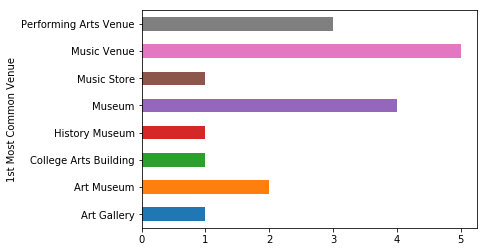

In [204]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
df1.plot(kind='barh')


We can see that "Music Avenue" is the most popular, followed by "Museum" and "Performing arts Avenue"

#### What is the second most sought after Cultural Avenue amonst all Neighbourhoods?

In [205]:
toronto_2best = toronto_merged[['Neighborhood','2nd Most Common Venue']]

In [206]:
df1 = toronto_2best.groupby(['2nd Most Common Venue'])['2nd Most Common Venue'].count()

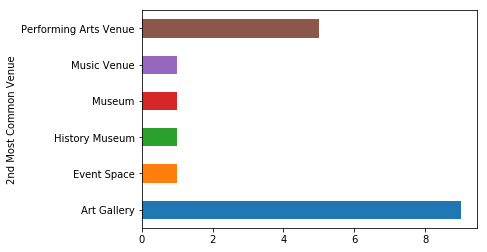

In [207]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
df1.plot(kind='barh')


"Art Gallery" followed by "Performing Arts Venue" are the most commoned second choices amongst all neighbourhoods

#### What is the third most sought after Cultural Avenue amonst all Neighbourhoods?

In [208]:
toronto_3best = toronto_merged[['Neighborhood','3rd Most Common Venue']]

In [209]:
df1 = toronto_3best.groupby(['3rd Most Common Venue'])['3rd Most Common Venue'].count()

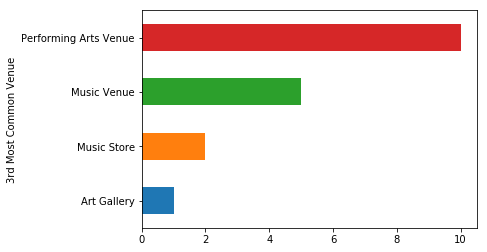

In [210]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
df1.plot(kind='barh')


"Performing Arts Venue" followed by "Music Venue" are the third most popular cultural places

Graphs are a great way to get insights quickly. In this case, we can clearly see that the most overall rated cultural place is "Performing Arts Venue" followed by "Music Avenue" when combining all the data.

Our advice to the stakeholders would be to increase this particular Avenue type if possible and make sure to increase the budget on marketing the other cultural avenues as well.